## Online Gaming Anxiety Data
Я решил взять следующий датасет: https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data/data
В нём провели опрос 13.5 тысяч геймеров на предмет их удовлетворённости жизнью, тревожности и социальных фобий. 
Хочу попробовать выяснить связь тревожности с другими параметрами (игра, количество часов игры и т.д.).

In [8]:
# import xgboost
# import shap

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, mean_absolute_error as mae

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [66]:
df = pd.read_csv("GamingStudy_data.csv", encoding = 'ISO-8859-1')
df.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [71]:
len(df['S. No.'])

13464

In [72]:
len(df.columns)

55

In [12]:
reduce_mem_usage(df)

Memory usage of dataframe is 5.65 MB
Memory usage after optimization is: 1.81 MB
Decreased by 67.9%


,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.003906,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.007812,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.039062,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.066406,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.089844,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13459,14246,42057.757812,1,0,0,1,0,1,1,Not difficult at all,...,France,France,Reddit,Multiplayer - online - with strangers,Accept,4,28,7.0,FRA,FRA
13460,14247,42057.812500,3,3,3,3,2,3,3,Extremely difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,20,23,25.0,USA,USA
13461,14248,42058.167969,0,0,0,0,0,0,0,Not difficult at all,...,Norway,Norway,Reddit,Multiplayer - online - with real life friends,Accept,0,32,10.0,NOR,NOR
13462,14249,42058.246094,3,2,1,3,0,1,3,Somewhat difficult,...,Canada,Canada,Reddit,Singleplayer,Accept,13,16,32.0,CAN,CAN


In [13]:
# Избавимся от заведомо ненужных колонок
df.drop(columns=['Timestamp', 'highestleague', 'Reference', 'accept', 'Residence_ISO3', 'Birthplace_ISO3'], inplace=True)

Избавляемся от выбросов

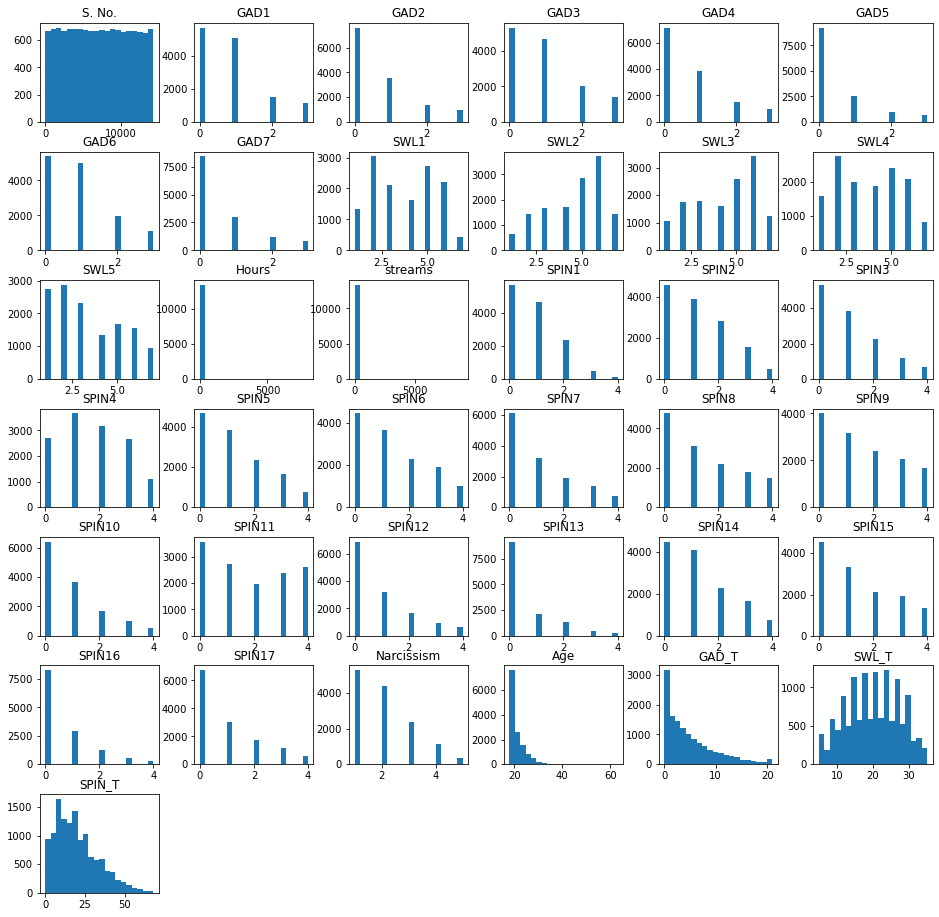

In [14]:
df.hist(figsize=(16,16), bins=20, grid=False);

In [15]:
df['streams'].dropna().sort_values().tail()

7615     140.0
5641     168.0
8418     200.0
9435     420.0
3860    9001.0
Name: streams, dtype: float32

In [16]:
df['Hours'].dropna().sort_values().tail()

7615      140.0
13279     150.0
8961      160.0
9435      420.0
3860     8000.0
Name: Hours, dtype: float32

In [17]:
df['Age'].dropna().sort_values().tail()

13325    50
82       50
3460     50
2435     56
352      63
Name: Age, dtype: int8

In [18]:
df.loc[df['Hours'] > 160, 'Hours'] = df['Hours'].median()
df.loc[df['streams'] > 160, 'streams'] = df['streams'].median()

In [19]:
data_num_feat = df.select_dtypes(include=('int8', 'int16', 'int32', 'float32'))
data_num_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S. No.      13464 non-null  int16  
 1   GAD1        13464 non-null  int8   
 2   GAD2        13464 non-null  int8   
 3   GAD3        13464 non-null  int8   
 4   GAD4        13464 non-null  int8   
 5   GAD5        13464 non-null  int8   
 6   GAD6        13464 non-null  int8   
 7   GAD7        13464 non-null  int8   
 8   SWL1        13464 non-null  int8   
 9   SWL2        13464 non-null  int8   
 10  SWL3        13464 non-null  int8   
 11  SWL4        13464 non-null  int8   
 12  SWL5        13464 non-null  int8   
 13  Hours       13434 non-null  float32
 14  streams     13364 non-null  float32
 15  SPIN1       13340 non-null  float32
 16  SPIN2       13310 non-null  float32
 17  SPIN3       13324 non-null  float32
 18  SPIN4       13305 non-null  float32
 19  SPIN5       13298 non-nul

Посмотрим распределение результатов всех трёх опросников. Начнём с GAD. Значения больше 10 считаются признаком имеющегося расстройства, для таких пациентто рекомендуется дополнительное обследование.

(0.0, 1670.0)

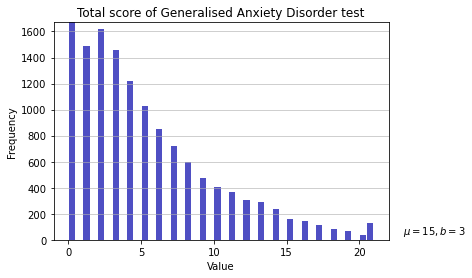

In [20]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df.GAD_T, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Generalised Anxiety Disorder test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

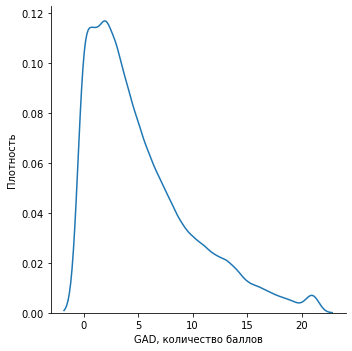

In [21]:
gad_plot = sns.displot(df, x='GAD_T', kind='kde', bw_adjust=.85)
gad_plot.set(ylabel='Плотность', xlabel='GAD, количество баллов')
gad_plot.savefig('gad_plot')

У нас имеются респонденты, для которых значения GAD больше 10. Сравним количество таких пользователей. 

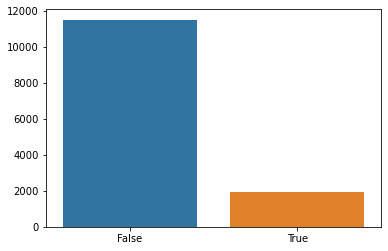

In [22]:
sns.barplot(x=(df['GAD_T'] > 10).value_counts().index, y=(df['GAD_T'] > 10).value_counts().values)
plt.show()

Имеется значительный перекос, тем не менее, попытаемся научиться предсказывать таких людей без опросника.

Взглянем также на SWL, опросник, оценивающий удовлетворённость жизнью.

(0.0, 640.0)

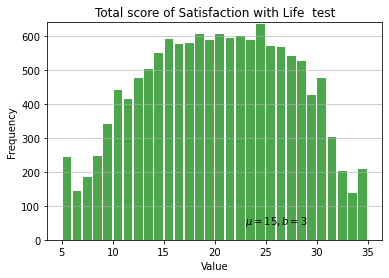

In [23]:
n, bins, patches = plt.hist(x=df.SWL_T, bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Satisfaction with Life  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

В основном респонденты удовлетворены жизнью.

(0.0, 860.0)

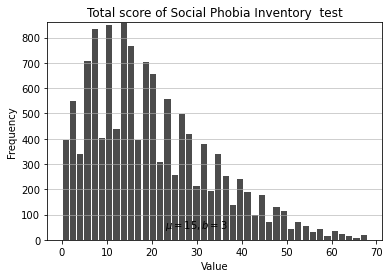

In [24]:
n, bins, patches = plt.hist(x=df.SPIN_T, bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Social Phobia Inventory  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [25]:
df.SPIN_T.isna().sum()

650

In [26]:
df.SPIN_T.fillna(df.SPIN_T.mean() , inplace=True)

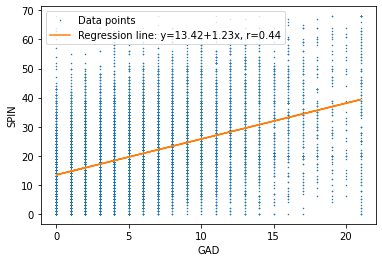

In [27]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df.GAD_T, df.SPIN_T)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SPIN_T, linewidth=0, marker='s', ms = 0.5, label='Data points')
ax.plot(df.GAD_T, intercept + slope * df.GAD_T, label=line)
ax.set_xlabel('GAD')
ax.set_ylabel('SPIN')
ax.legend(facecolor='white')
plt.show()

Корреляция слабая

In [28]:
df.SWL_T.isna().sum()

0

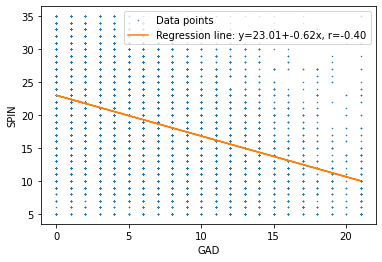

In [29]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df.GAD_T, df.SWL_T)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SWL_T, linewidth=0, marker='s', ms=0.5, label='Data points')
ax.plot(df.GAD_T, intercept + slope * df.GAD_T, label=line)
ax.set_xlabel('GAD')
ax.set_ylabel('SPIN')
ax.legend(facecolor='white')
plt.show()

Опять же корреляция слабая. Откажемся от результатов опросников SPIN и SWL и сосредоточимся на GAD.

In [30]:
columns_for_drop = ['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 
                    'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SPIN1', 'SPIN2',
                    'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 
                    'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17']

In [31]:
df.drop(columns = columns_for_drop, inplace=True)

In [32]:
df.describe()

,S. No.,Hours,streams,Narcissism,Age,GAD_T,SWL_T,SPIN_T
count,13464.000000,13434.000000,13364.000000,13441.000000,13464.000000,13464.000000,13464.000000,13464.000000
mean,7096.839201,21.623568,10.503442,2.027677,20.930407,5.211973,19.788844,19.848440
std,4114.478220,13.777575,10.232300,1.061816,3.300897,4.713267,7.229243,13.138386
min,1.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000
25%,3532.750000,12.000000,4.000000,1.000000,18.000000,2.000000,14.000000,10.000000
50%,7087.500000,20.000000,8.000000,2.000000,20.000000,4.000000,20.000000,18.000000
75%,10654.250000,28.000000,15.000000,3.000000,22.000000,8.000000,26.000000,27.000000
max,14250.000000,160.000000,140.000000,5.000000,63.000000,21.000000,35.000000,68.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   S. No.      13464 non-null  int16   
 1   GADE        12815 non-null  category
 2   Game        13464 non-null  category
 3   Platform    13464 non-null  category
 4   Hours       13434 non-null  float32 
 5   earnings    13464 non-null  category
 6   whyplay     13464 non-null  category
 7   League      11626 non-null  category
 8   streams     13364 non-null  float32 
 9   Narcissism  13441 non-null  float32 
 10  Gender      13464 non-null  category
 11  Age         13464 non-null  int8    
 12  Work        13426 non-null  category
 13  Degree      13464 non-null  category
 14  Birthplace  13464 non-null  category
 15  Residence   13464 non-null  category
 16  Playstyle   13464 non-null  category
 17  GAD_T       13464 non-null  int8    
 18  SWL_T       13464 non-null  int8    
 19  SPIN

array([[<AxesSubplot:title={'center':'S. No.'}>,
        <AxesSubplot:title={'center':'Hours'}>,
        <AxesSubplot:title={'center':'streams'}>],
       [<AxesSubplot:title={'center':'Narcissism'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'GAD_T'}>],
       [<AxesSubplot:title={'center':'SWL_T'}>,
        <AxesSubplot:title={'center':'SPIN_T'}>, <AxesSubplot:>]],
      dtype=object)

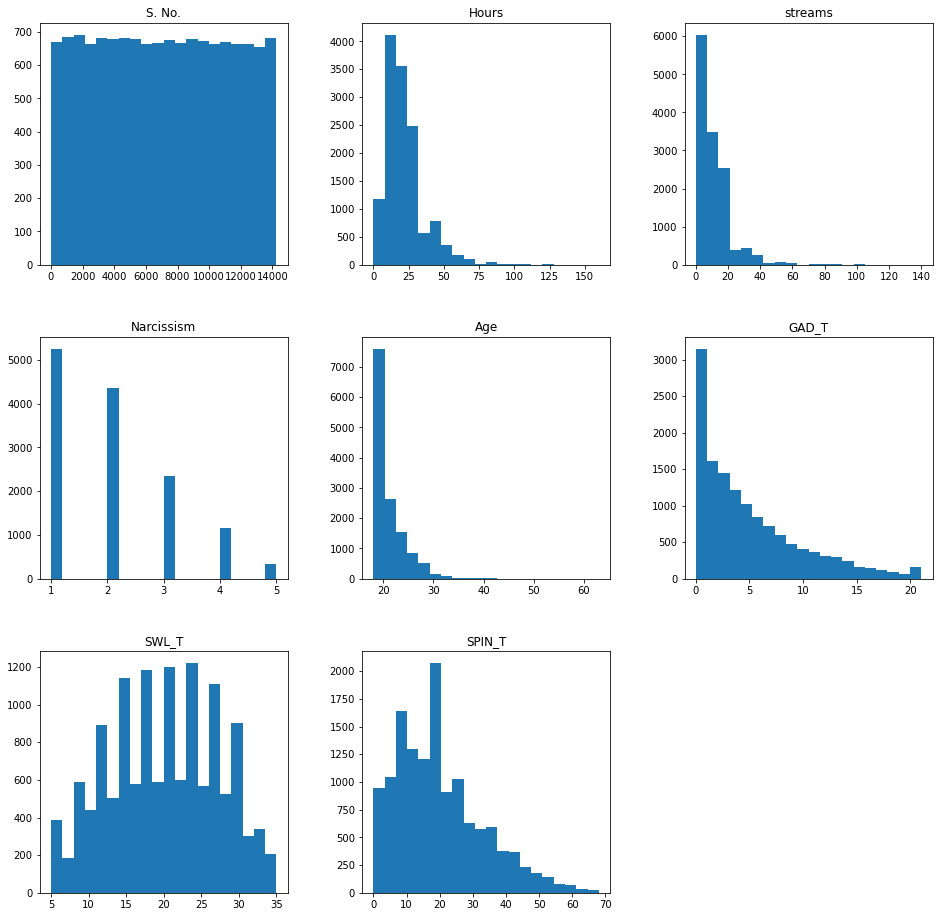

In [34]:
df.hist(figsize=(16,16), bins=20, grid=False)

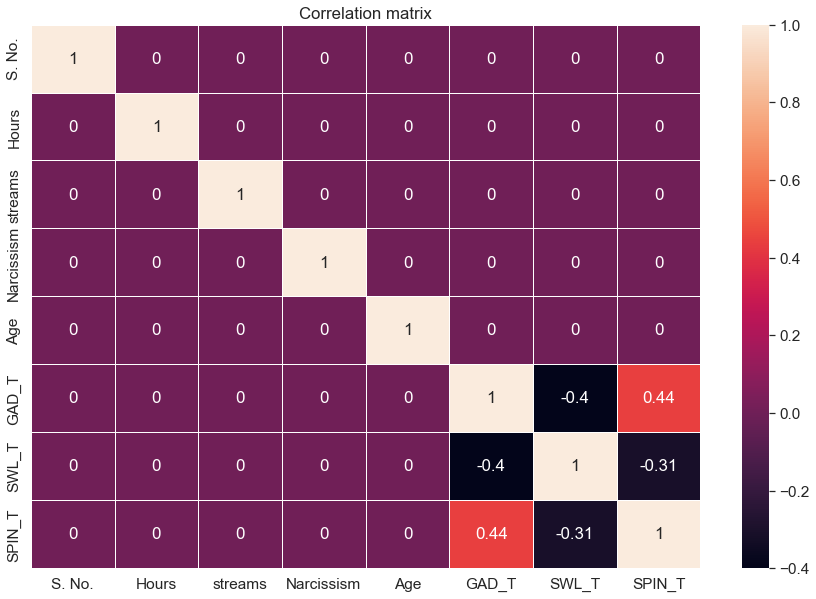

In [35]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='rocket')
plt.title('Correlation matrix')
plt.show()

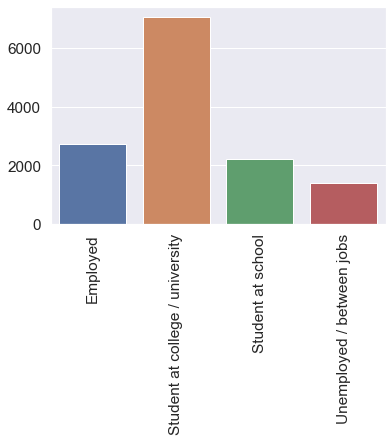

In [36]:
barplt = sns.barplot(x=df['Work'].value_counts().index, y=df['Work'].value_counts().values)
for label in barplt.get_xticklabels():
    label.set_rotation(90)
plt.show()

### Избавляемся от NaN

In [37]:
df.isna().sum()

S. No.           0
GADE           649
Game             0
Platform         0
Hours           30
earnings         0
whyplay          0
League        1838
streams        100
Narcissism      23
Gender           0
Age              0
Work            38
Degree           0
Birthplace       0
Residence        0
Playstyle        0
GAD_T            0
SWL_T            0
SPIN_T           0
dtype: int64

In [38]:
df.GADE.fillna(df.GADE.value_counts().index[1] , inplace=True)
df.Hours.fillna(df.Hours.mean() , inplace=True)
df.streams.fillna(df.streams.mean() , inplace=True)
df.League.fillna(df.League.value_counts().index[1] , inplace=True)
df.Narcissism.fillna(df.Narcissism.value_counts().index[1] , inplace=True)
df.Work.fillna(df.Work.value_counts().index[1] , inplace=True)

In [39]:
df.isna().sum()

S. No.        0
GADE          0
Game          0
Platform      0
Hours         0
earnings      0
whyplay       0
League        0
streams       0
Narcissism    0
Gender        0
Age           0
Work          0
Degree        0
Birthplace    0
Residence     0
Playstyle     0
GAD_T         0
SWL_T         0
SPIN_T        0
dtype: int64

In [40]:
cat_columns = ['GADE', 'GAME', 'Platform', 'Gender', 'Work', 'Degree']

In [41]:
df.drop(columns=['SWL_T', 'SPIN_T', 'S. No.'], inplace=True)

In [42]:
for col in ['earnings', 'whyplay', 'League', 'Playstyle']:
    print("_"*20)
    print(col)
    print(df[col].nunique())
    print(df.groupby(col).filter(lambda x: x[col].count() > 35)[col].nunique())

____________________
earnings
314
3
____________________
whyplay
407
4
____________________
League
1455
68
____________________
Playstyle
298
5


In [43]:
def categories_clip(df, column, threshold=35):
    all_categories = df[column].unique()
    most_popular = df[column].value_counts().index[0]
    popular_categories = df.groupby(col).filter(lambda x: x[col].count() > threshold)[col].unique()
    df.loc[~df[column].isin(popular_categories)][column] = most_popular

In [44]:
for col in ['earnings', 'whyplay', 'League', 'Playstyle']:
    categories_clip(df, col)

Города пока выкинем

In [45]:
df.drop(columns=['Birthplace', 'Residence'], inplace=True)

In [46]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['GAD_T']), df['GAD_T'], random_state=0)

In [47]:
X_train

,GADE,Game,Platform,Hours,earnings,whyplay,League,streams,Narcissism,Gender,Age,Work,Degree,Playstyle
204,Not difficult at all,League of Legends,PC,14.0,I play for fun,having fun,Plat,10.0,1.0,Male,19,Student at college / university,High school diploma (or equivalent),Multiplayer - online - with online acquaintanc...
466,Not difficult at all,Other,PC,20.0,I play for fun,having fun,gold,5.0,1.0,Male,20,Employed,High school diploma (or equivalent),Multiplayer - online - with real life friends
9942,Somewhat difficult,League of Legends,PC,24.0,I play for fun,winning,Gold,5.0,5.0,Male,19,Student at college / university,High school diploma (or equivalent),Multiplayer - online - with strangers
11268,Not difficult at all,League of Legends,PC,18.0,I play for fun,improving,Silver 2,2.0,2.0,Male,18,Student at school,None,Multiplayer - online - with strangers
175,Somewhat difficult,Destiny,"Console (PS, Xbox, ...)",14.0,I play for fun,having fun,Silver,1.0,1.0,Male,29,Employed,"Ph.D., Psy. D., MD (or equivalent)",Multiplayer - online - with strangers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Not difficult at all,League of Legends,PC,50.0,I play for fun,improving,Platinum,1.0,1.0,Male,20,Student at college / university,High school diploma (or equivalent),Multiplayer - online - with real life friends
3264,Not difficult at all,League of Legends,PC,20.0,I play for fun,having fun,Silver 1,25.0,3.0,Male,18,Unemployed / between jobs,High school diploma (or equivalent),Multiplayer - online - with real life friends
9845,Very difficult,League of Legends,PC,7.0,I play for fun,having fun,Silver,1.0,4.0,Male,18,Student at school,None,Multiplayer - online - with real life friends
10799,Somewhat difficult,League of Legends,PC,20.0,I play for fun,having fun,Gold,4.0,3.0,Male,18,Student at school,High school diploma (or equivalent),Multiplayer - online - with real life friends


In [48]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10098 entries, 204 to 2732
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GADE        10098 non-null  category
 1   Game        10098 non-null  category
 2   Platform    10098 non-null  category
 3   Hours       10098 non-null  float32 
 4   earnings    10098 non-null  category
 5   whyplay     10098 non-null  category
 6   League      10098 non-null  category
 7   streams     10098 non-null  float32 
 8   Narcissism  10098 non-null  float32 
 9   Gender      10098 non-null  category
 10  Age         10098 non-null  int8    
 11  Work        10098 non-null  category
 12  Degree      10098 non-null  category
 13  Playstyle   10098 non-null  category
dtypes: category(10), float32(3), int8(1)
memory usage: 430.4 KB


In [50]:
continuous_columns = ["Hours", "streams", 'Narcissism', 'Age']
cat_columns = ['GADE', 'Game', 'Platform', 'Gender', 'Work', 'Degree', 'earnings', 'whyplay', 'League', 'Playstyle']
final_transformers = list()

In [73]:
len(continuous_columns + cat_columns)

14

In [51]:
for cat_col in cat_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [52]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestRegressor(random_state=42)),
])

In [53]:
feats

FeatureUnion(transformer_list=[('GADE',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='GADE')),
                                                ('ohe',
                                                 OHEEncoder(key='GADE'))])),
                               ('Game',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Game')),
                                                ('ohe',
                                                 OHEEncoder(key='Game'))])),
                               ('Platform',
                                Pipeline(steps=[('selector',
                                                 FeatureSelector(column='Platform')),
                                                ('ohe',
                                                 OHEEncoder(key='Platform'))])),
                               (...
    

In [54]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('GADE',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='GADE')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='GADE'))])),
                                                ('Game',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Game')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Game'))])),
                                                ('Platform',
                                                 Pipeline(steps=[('selector',
                              

In [55]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict(X_test)
preds[:10]

array([2.32, 6.69, 6.32, 1.54, 4.49, 6.08, 4.7 , 3.13, 2.69, 1.83])

In [61]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3))         
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, pred_values.max()], [0, true_values.max()], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.905
RMSE:	1.446
MSE:	2.09
MAE:	1.081


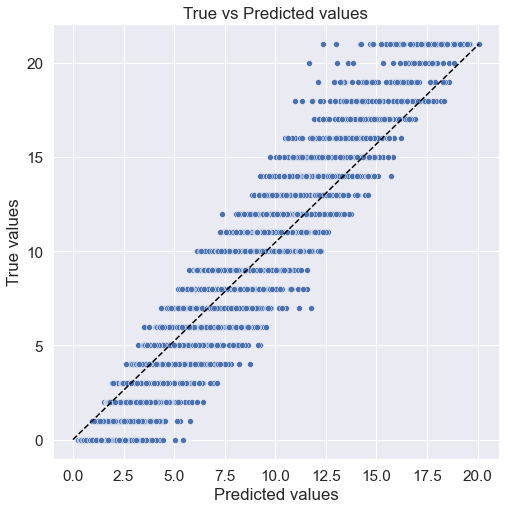

In [62]:
REPORTS_FILE_PATH = ''
y_train_preds = pipeline.predict(X_train)
evaluate_preds(y_train, y_train_preds, save=True)